In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn
import numpy
import pandas
import datetime
import pickle
import random
import battery_size_functions
import imp
imp.reload(battery_size_functions)

<module 'battery_size_functions' from '/home/ignavermeulen/modeling_charging_behavior/battery_size_functions.py'>

In [2]:
with open('data/sessions/ChargeSessions_general.pkl', 'rb') as f:
    x = pickle.load(f)

In [3]:
x = x.sort_values(by = 'start_connection', ascending = True)


In [4]:
example_data = x.iloc[range(1000, 2000),:]
example_data['battery_size'] = example_data.apply(lambda row: random.random()*100,axis=1)
example_data['battery_category'] = example_data.apply(lambda row: random.choice(['phev', 'fev_low', 'fev_high']), axis=1)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [5]:
first_appearance = example_data['start_connection'].iloc[0]
last_appearance = example_data['start_connection'].iloc[-1]
first_appearance, last_appearance

(Timestamp('2014-01-02 13:43:38'), Timestamp('2014-01-03 14:52:00'))

In [40]:
parameter = 'transform_parameters'
probs_no_transform = numpy.arange(0.0, 1.2, 0.20)
values = []

for prob in probs_no_transform:
    values.append({"prob_no_transform": prob,
                "prob_to_low_fev": 0.0,
                "prob_to_high_fev": 1 - prob})

measures = ['simulated_sessions']
number_of_agents, simulation_repeats = 10000, 5

experiment_dir = 'data/experiment_results/experiment_simulation_measures_%s_varying_%s' % (measures[0], parameter)
results = {}
for value in values:
    experiment_filename = experiment_dir + '/%s_%s_%s_agents_%s_simulation_repeats.pkl' % (str(value['prob_no_transform']), parameter, str(number_of_agents), str(simulation_repeats))
    with open(experiment_filename, 'rb') as f:
        results[value['prob_no_transform']] = pickle.load(f)

In [45]:
def get_connection_durations(data, cs, end_time, environment):
    connection_durations = []
    for i, session in data.iterrows():
        connection_durations.append(min(session['end_connection'], end_time) - session['start_connection'])
    return battery_size_functions.sum_timedeltas(connection_durations) / environment.css_info[cs]['amount_of_sockets']


def get_frac_occupied_per_week(data, cs,):
    fractions = []
    
    return


# def get_kwh_per_week(data):
# #     first_appearance = data['start_connection'].iloc[0].date()
# #     last_appearance = data['start_connection'].iloc[0].date()
# #     summed_kwh = sum(data.kWh)
# #     return (1.0*summed_kwh / (last_appearance - first_appearance).days * 7)

#     first_appearance = data['start_connection'].iloc[0].date()
#     last_appearance = data['start_connection'].iloc[0].date()
#     nr_weeks = (last_appearance - first_appearance).days * 7
#     kwhs = []
#     for week in range(nr_weeks):
#         sessions_week = data[(data['start_connection'] >= first_appearance) & (data['start_connection'] <= first_appearance + datetime.timedelta(days=7))]
#         kwhs.append(numpy.mean(sessions_week.kWh))
#     return numpy.mean(kwhs)





# def get_nr_users_per_week(data):
#     first_appearance = data['start_connection'].iloc[0].date()
#     last_appearance = data['start_connection'].iloc[0].date()
#     nr_weeks = (last_appearance - first_appearance).days * 7
#     nr_users = []
#     for week in range(nr_weeks):
#         sessions_week = data[(data['start_connection'] >= first_appearance) & (data['start_connection'] <= first_appearance + datetime.timedelta(days=7))]
#         nr_users.append(len(sessions_week.ID.unique()))
#     return numpy.mean(nr_users)



def get_results(data):
    with open('data/simulation_pkls/environment.pkl', 'rb') as environment_file:
        environment = pickle.load(environment_file)
    results = {}
    for cs in data.location_key.unique():
#         print(cs)
        sessions_at_cs = data.loc[data.location_key == cs]
        sessions_at_cs = sessions_at_cs.sort_values(by = 'start_connection')
        first_appearance = sessions_at_cs['start_connection'].iloc[0]
        last_appearance = sessions_at_cs['start_connection'].iloc[-1]
        nr_weeks = int((last_appearance - first_appearance).days / 7  + 1)
        nr_users = []
        kwhs = []
        nr_sessions = []
        connection_durations = []
        results[cs] = {}
        for week in range(nr_weeks):
            sessions_week = sessions_at_cs[(sessions_at_cs['start_connection'] >= first_appearance + datetime.timedelta(days=7) * week) & 
                                           (sessions_at_cs['start_connection'] <= first_appearance + datetime.timedelta(days=7) * (week + 1))]
            nr_users.append(len(sessions_week.ID.unique()))
            kwhs.append(numpy.mean(sessions_week.kWh))
            nr_sessions.append(len(sessions_week))
            connection_durations.append(get_connection_durations(sessions_week, cs, 
                                    first_appearance + datetime.timedelta(days=7) * week, environment))
        results[cs]['connection_duration_per_week'] = connection_durations
        results[cs]['kwh_per_week'] = kwhs
#         results[cs]['frac_occupied_per_week'] = get_frac_occupied_per_week(sessions_at_cs)
        results[cs]['nr_users_per_week'] = nr_users
        results[cs]['nr_sessions_per_week'] = nr_sessions
    return results
        

In [13]:
r = get_results(example_data)

In [62]:
for key in results:
    print(key)
    for i, run in enumerate(results[key]):
        print(i, len(results[key]))
        print(run.columns)
        print(len(run))
        for idx, session in run.iterrows():
            print(session)
            print(min(session['end_connection'], end_time) - session['start_connection'])
            break
        break
        
    break
#         processed_results[key].append(get_results(run))

0.0
0 5
Index(['latitude', 'region_abbreviation', 'longitude', 'amount_of_sockets',
       'subdistrict', 'location_key', 'address', 'placement_date', 'district',
       'provider', 'city', 'start_connection', 'end_connection', 'postal_code',
       'ID', 'kWh'],
      dtype='object')
230431
latitude                                                         51.8732
region_abbreviation                                            Rotterdam
longitude                                                         4.4359
amount_of_sockets                                                      4
subdistrict                                               Waalhaven Zuid
location_key                                                        1126
address                                             Van Veenendaalweg 11
placement_date                                       2014-10-03 08:59:04
district                                      Haven en industriegebieden
provider                                          

NameError: name 'end_time' is not defined

In [46]:
processed_results = {}
prev = datetime.datetime.now()
for key in results:
    print(key, datetime.datetime.now() - prev)
    prev = datetime.datetime.now()
    processed_results[key] = []
    for i, run in enumerate(results[key]):
        print(i, len(results[key]))
        processed_results[key].append(get_results(run))

0.0 0:00:00.000305
0 5
1 5
2 5
3 5
4 5
0.2 0:10:58.135454
0 5
1 5
2 5
3 5
4 5
0.8 0:11:13.720914
0 5
1 5
2 5
3 5
4 5
0.6 0:11:40.895498
0 5
1 5
2 5
3 5
4 5
1.0 0:11:44.190721
0 5
1 5
2 5
3 5
4 5
0.4 0:12:11.636539
0 5
1 5
2 5
3 5
4 5


In [ ]:
df_processed_results = pandas.DataFrame.from_dict(processed_results)

In [48]:
with open('data/battery_size/case_study_processed_results.pkl', 'wb') as f:
    pickle.dump(processed_results, f)

In [53]:
processed_results[0.0][0]['2210']

{'connection_duration_per_week': [numpy.timedelta64(74970000000000,'ns'),
  numpy.timedelta64(-171660000000000,'ns'),
  numpy.timedelta64(-1531440000000000,'ns'),
  numpy.timedelta64(-647220000000000,'ns'),
  numpy.timedelta64(-1206510000000000,'ns'),
  numpy.timedelta64(-4170930000000000,'ns'),
  numpy.timedelta64(-1549140000000000,'ns'),
  numpy.timedelta64(-4091940000000000,'ns'),
  numpy.timedelta64(-4610220000000000,'ns'),
  datetime.timedelta(0),
  datetime.timedelta(0),
  numpy.timedelta64(-3310740000000000,'ns'),
  numpy.timedelta64(-7107780000000000,'ns'),
  numpy.timedelta64(-7671840000000000,'ns'),
  numpy.timedelta64(-4055730000000000,'ns'),
  numpy.timedelta64(-4400160000000000,'ns'),
  numpy.timedelta64(-4572240000000000,'ns'),
  datetime.timedelta(0),
  numpy.timedelta64(-5407080000000000,'ns'),
  numpy.timedelta64(-11257050000000000,'ns'),
  numpy.timedelta64(-5952180000000000,'ns'),
  numpy.timedelta64(-6257850000000000,'ns'),
  numpy.timedelta64(-12904950000000000,'ns

In [6]:
def create_plot_data(data):
    plotting_data = {}
    plotting_data['prob_no_transform'] = [] 
    plotting_data['connection_duration_per_week_in_days'] = []
    plotting_data['kwh_per_week'] = []
    plotting_data['nr_users_per_week'] = []
    plotting_data['nr_sessions_per_week'] = []
    plotting_data['total_kwh'] = []
    counter = 0
    count  = 0
    for prob_no_transform in data:
        print(prob_no_transform)
        for i, run in enumerate(data[prob_no_transform]):
#             print(i, len(data[prob_no_transform]))
            for pole in run:
                try:
                    plotting_data['prob_no_transform'].append(prob_no_transform)
                    connection_duration_per_week_in_days_ = [val.total_seconds() / 60 / 60 / 24 
                        if isinstance(val, datetime.timedelta) else val.item() / 1000000000 / 60 / 60/ 24
                                                            for val in run[pole]['connection_duration_per_week']] 
                    for val in connection_duration_per_week_in_days_:
                        if val < 0:
                            count +=1
                    connection_duration_per_week_in_days = [val for val in connection_duration_per_week_in_days_ if val > 0]
                    plotting_data['connection_duration_per_week_in_days'].append(numpy.nanmean(connection_duration_per_week_in_days))
                    plotting_data['kwh_per_week'].append(numpy.nanmean(run[pole]['kwh_per_week']))
                    plotting_data['total_kwh'].append(numpy.nansum(run[pole]['kwh_per_week']))
                    plotting_data['nr_users_per_week'].append(numpy.nanmean(run[pole]['nr_users_per_week']))
                    plotting_data['nr_sessions_per_week'].append(numpy.nanmean(run[pole]['nr_sessions_per_week']))
                except Exception as e:
                    print(run[pole])
                    counter += 1
                    raise e
                    continue
    print(counter)
    print(count)
#     print(len(plotting_data['prob_no_transform']), 
#        len(plotting_data['connection_duration_per_week']),
#         len(plotting_data['kwh_per_week']),
#         len(plotting_data['nr_users_per_week']),
#         len(plotting_data['nr_sessions_per_week']))
    return pandas.DataFrame.from_dict(plotting_data)
            

In [172]:
numpy.nansum(processed_results_2[0.0][0]['4597']['kwh_per_week'])

111.0

In [176]:
%time plotting_data_2 = create_plot_data(processed_results_2)

0.0
0.2
0.8
0.6
1.0
0.4
0
0
CPU times: user 7.55 s, sys: 4 ms, total: 7.56 s
Wall time: 7.56 s


In [103]:
%time plotting_data_2 = create_plot_data(processed_results_2)

0.0
0.2
0.8
0.6
1.0
0.4
0
CPU times: user 3.18 s, sys: 0 ns, total: 3.18 s
Wall time: 3.18 s


In [104]:
plotting_data.head()

,kwh_per_week,nr_sessions_per_week,nr_users_per_week,prob_no_transform
0,6.535417,1.098039,0.882353,0
1,7.928571,0.333333,0.333333,0
2,6.363636,0.342857,0.314286,0
3,5.000000,0.090909,0.090909,0
4,6.232759,0.941176,0.784314,0


In [178]:
plotting_data['prob_transform'] = plotting_data.apply(
    lambda row: 1 - row.prob_no_transform, axis = 1)

In [4]:
with open('data/battery_size/case_study_processed_results_3.pkl', 'rb') as f:
    processed_results_3 = pickle.load(f)

In [7]:
%time plotting_data_3 = create_plot_data(processed_results_3)

0.0
0.2
0.8
0.6
1.0
0.4
0
0
CPU times: user 7.79 s, sys: 0 ns, total: 7.79 s
Wall time: 7.79 s


In [8]:
plotting_data_3['prob_transform'] = plotting_data_3.apply(
    lambda row: 1 - row.prob_no_transform, axis = 1)

In [186]:
R = 61
G = 84
B = 151
my_rgb = (R/255, G/255, B/255)

In [30]:
def plot_case_study_results(df, y, color = None, title = '', ylabel = ''):
    seaborn.set(style='whitegrid', font_scale=2.5)
    fig = plt.figure(figsize=(16, 8))
    ax = seaborn.pointplot(x="prob_transform", y=y, 
                            data = df, capsize=.2, color = color, linestyles = '--', scale = 1.5, fliersize = 0) 
    plt.title(title,  fontsize = 30)
    plt.xlabel('Transform Probability')
    plt.ylabel(ylabel)



In [31]:
my_colors = {'main': '#6472A8', 'main_light': '#A3ACCD', 'main_dark': '#2F4085', 'main_light_light': '#E8EBF4',
            'low': '#B08C31', 'low_light': '#CEB779',
            'phev': '#B03331', 'phev_light': '#CD7C7A',
            'high': '#7CB630', 'high_light': '#AED27A'}



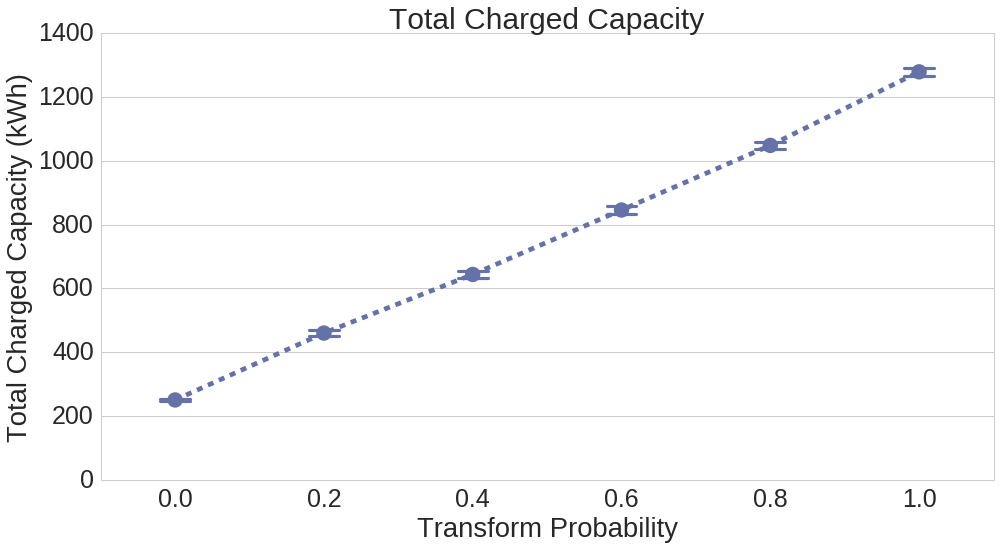

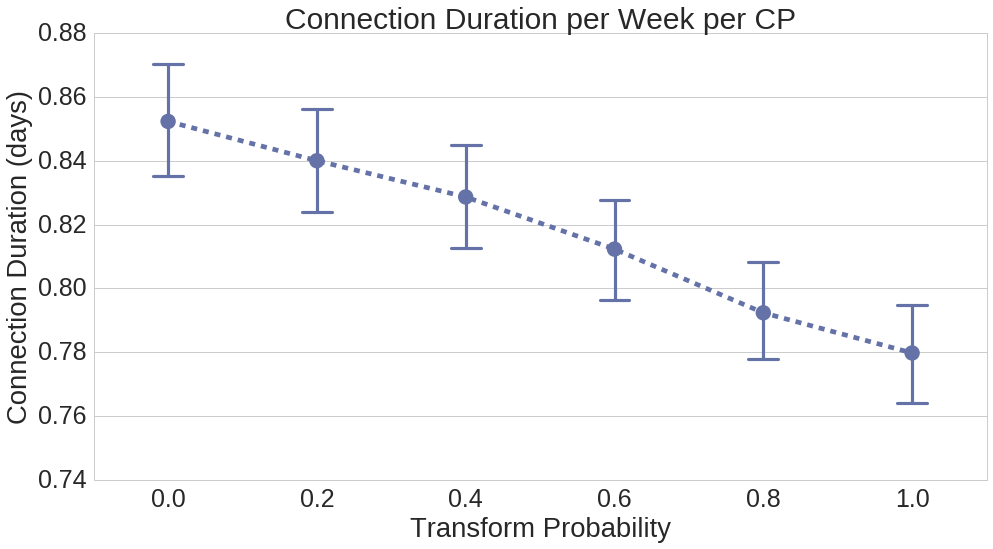

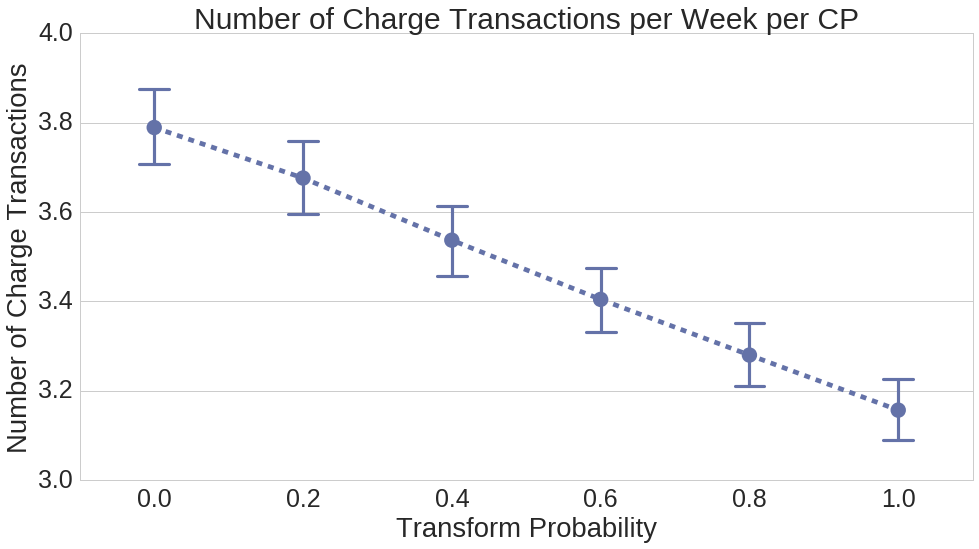

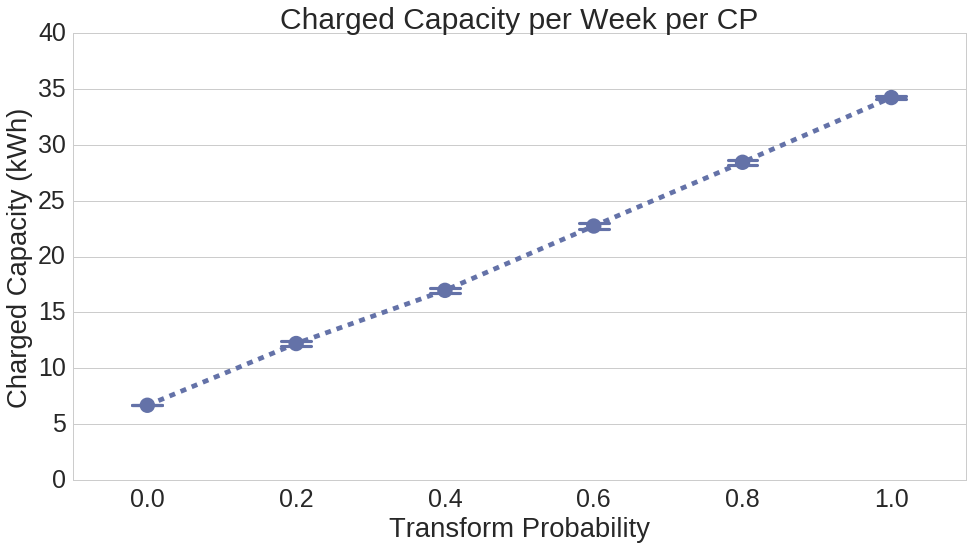

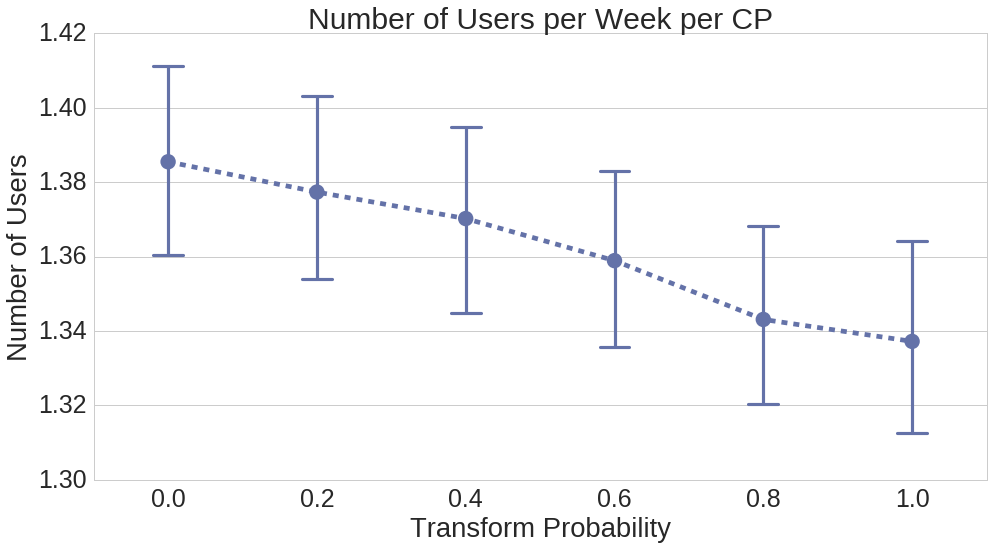

In [32]:
plot_case_study_results(plotting_data_3, 'total_kwh', color = my_colors['main'],
                       title = 'Total Charged Capacity', ylabel = 'Total Charged Capacity (kWh)')
plot_case_study_results(plotting_data_3, 'connection_duration_per_week_in_days', color = my_colors['main'],
                       title = 'Connection Duration per Week per CP', 
                       ylabel = 'Connection Duration (days)')
plot_case_study_results(plotting_data_3, 'nr_sessions_per_week', color = my_colors['main'],
                       title = 'Number of Charge Transactions per Week per CP',
                       ylabel = 'Number of Charge Transactions')
plot_case_study_results(plotting_data_3, 'kwh_per_week', color = my_colors['main'],
                       title = 'Charged Capacity per Week per CP',
                       ylabel = 'Charged Capacity (kWh)')
plot_case_study_results(plotting_data_3, 'nr_users_per_week', color = my_colors['main'],
                       title = 'Number of Users per Week per CP',
                       ylabel = 'Number of Users')

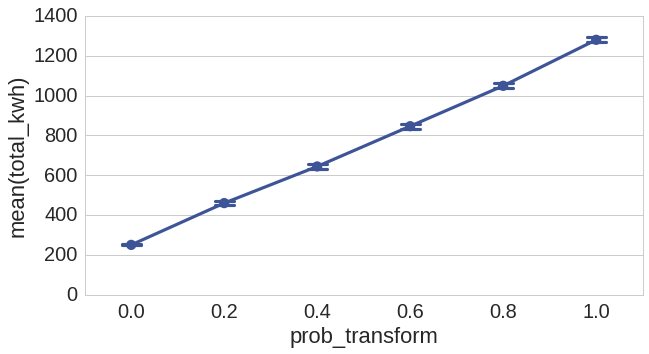

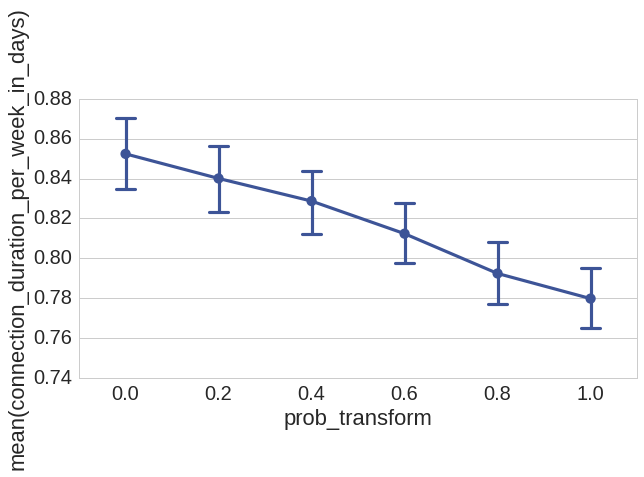

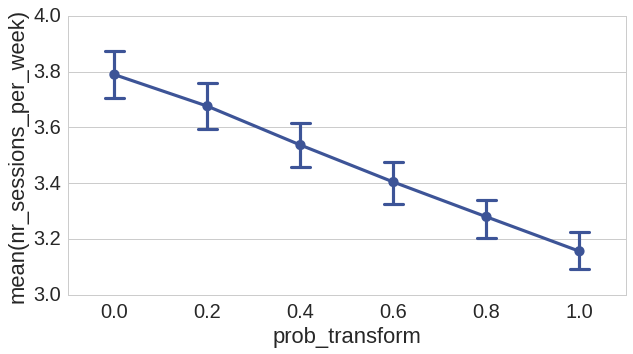

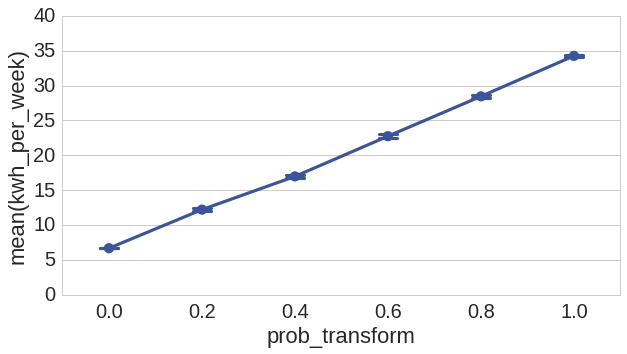

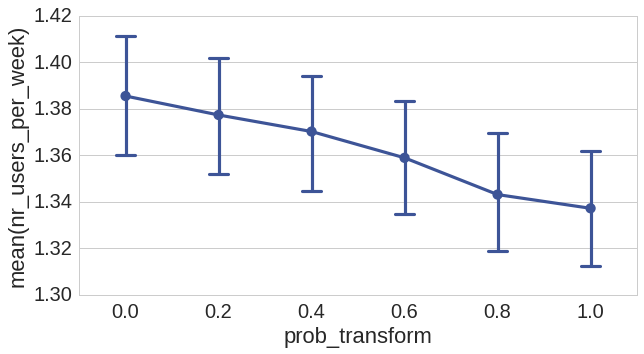

In [187]:
plot_case_study_results(plotting_data_3, 'total_kwh', color = my_rgb)
plot_case_study_results(plotting_data_3, 'connection_duration_per_week_in_days', color = my_rgb)
plot_case_study_results(plotting_data_3, 'nr_sessions_per_week', color = my_rgb)
plot_case_study_results(plotting_data_3, 'kwh_per_week', color = my_rgb)
plot_case_study_results(plotting_data_3, 'nr_users_per_week', color = my_rgb)

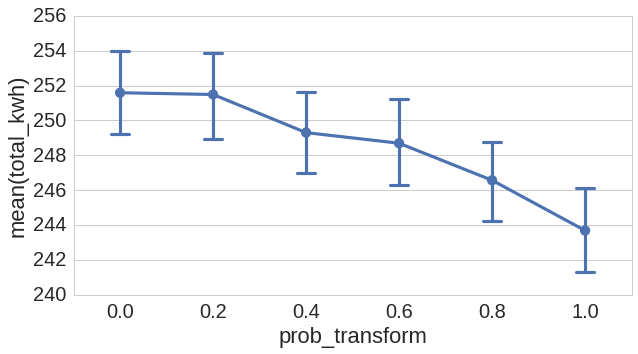

In [180]:
plot_case_study_results(plotting_data_2, 'total_kwh')

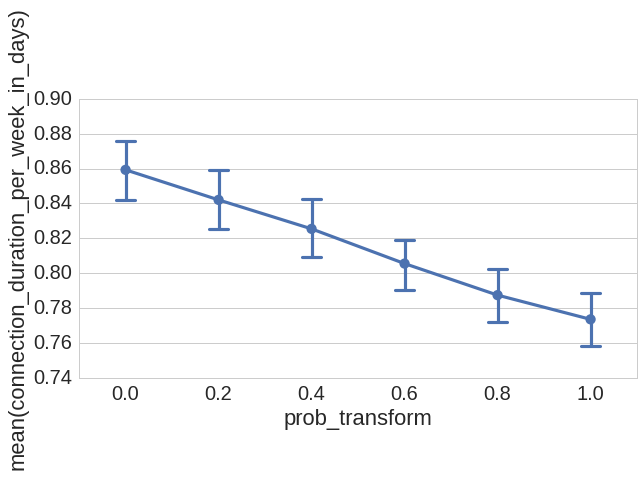

In [164]:
plot_case_study_results(plotting_data_2, 'connection_duration_per_week_in_days')

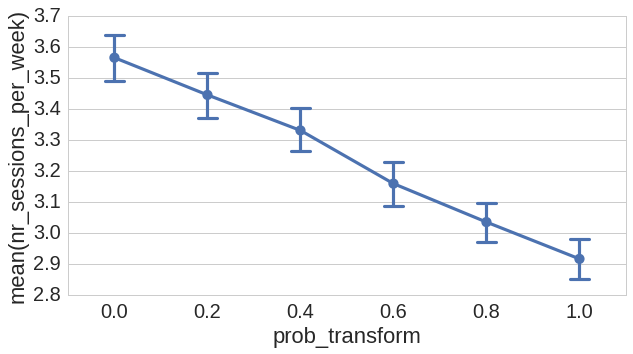

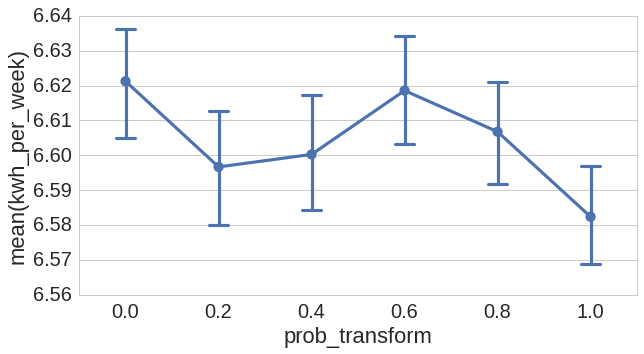

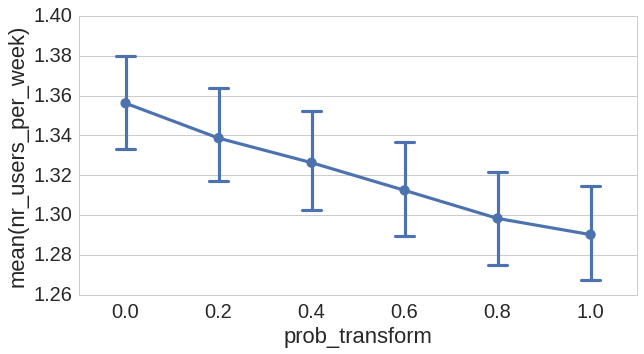

In [123]:
plot_case_study_results(plotting_data, 'nr_sessions_per_week')
plot_case_study_results(plotting_data, 'kwh_per_week')
plot_case_study_results(plotting_data, 'nr_users_per_week')

In [14]:
r

{'1015': {'connection_duration_per_week': [numpy.timedelta64(28500000000000,'ns')],
  'kwh_per_week': [5.3633333333333333],
  'nr_sessions_per_week': [3],
  'nr_users_per_week': [3]},
 '1019': {'connection_duration_per_week': [numpy.timedelta64(26561500000000,'ns')],
  'kwh_per_week': [33.530000000000001],
  'nr_sessions_per_week': [1],
  'nr_users_per_week': [1]},
 '1045': {'connection_duration_per_week': [numpy.timedelta64(158340000000000,'ns')],
  'kwh_per_week': [8.5999999999999996],
  'nr_sessions_per_week': [2],
  'nr_users_per_week': [2]},
 '105': {'connection_duration_per_week': [numpy.timedelta64(51690000000000,'ns')],
  'kwh_per_week': [8.0999999999999996],
  'nr_sessions_per_week': [1],
  'nr_users_per_week': [1]},
 '1058': {'connection_duration_per_week': [numpy.timedelta64(32189000000000,'ns')],
  'kwh_per_week': [0.0],
  'nr_sessions_per_week': [3],
  'nr_users_per_week': [3]},
 '1072': {'connection_duration_per_week': [numpy.timedelta64(73500000000000,'ns')],
  'kwh_per_

In [31]:
td = numpy.timedelta64(2530000000000,'ns')

In [47]:
td.astype('timedelta64[m]')

'2530000000000'

In [23]:
import datetime
now1 = datetime.datetime.now()
now2 = datetime.datetime.now()
timedelta = now2-now1
halfdt = timedelta/2.  #This works just fine

In [27]:
import operator
sum_ = datetime.timedelta(minutes = 0)
for item in [datetime.timedelta(minutes = 1), datetime.timedelta(minutes = 1), datetime.timedelta(minutes = 1)]:
    sum_ = operator.add(item, sum_)

In [29]:
sum_ / 2

datetime.timedelta(0, 90)